In [5]:
# Step 5.1: Setup (imports, paths, model + class mapping)
import os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model

# Define paths to trained model, saved class mapping, and test directory
MODEL_PATH = "/content/drive/MyDrive/Project 2 Data/Data/best_model.keras"
CLASS_INDEX_PATH = "/content/drive/MyDrive/Project 2 Data/Data/class_indices.json"
TEST_ROOT = "/content/drive/MyDrive/Project 2 Data/Data/test"

# Expected input image size and channel depth
TARGET_SIZE = (500, 500)  # (width, height)
N_CHANNELS = 3            # RGB

# Load model
model = load_model(MODEL_PATH)

# Load Class index mapping to interpret predictions correctly
if os.path.exists(CLASS_INDEX_PATH):
    with open(CLASS_INDEX_PATH, "r") as f:
        class_indices = json.load(f)  # {"crack":0,"missing-head":1,"paint-off":2}
    idx_to_class = {v: k for k, v in class_indices.items()}
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
else:
    # Fallback if mapping file not found
    class_names = ["crack", "missing-head", "paint-off"]
    idx_to_class = {i: c for i, c in enumerate(class_names)}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 28 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
# Step 5.2: Preprocess + predict helpers

def preprocess_image(path, target_size=(500, 500)):
    # Load an image from disk and resize to match model input
    img = load_img(path, target_size=target_size, color_mode="rgb")
    x = img_to_array(img).astype("float32") / 255.0
    # Add batch dimension so shape becomes (1, H, W, 3)
    x = np.expand_dims(x, axis=0)  # (1, H, W, 3)
    return img, x

def predict_softmax(x_batch):
    # Run model inference which returns class probabilities
    probs = model.predict(x_batch, verbose=0)[0]  # (C,)
    # Index of highest probability
    pred_idx = int(np.argmax(probs))
    return probs, pred_idx, idx_to_class[pred_idx]


In [7]:
# Step 5.3: Plot and save "Figure 3"-style result

def draw_result(img_PIL, probs, pred_label, true_label=None, save_path=None):
    plt.figure(figsize=(5,5))

    # Build titles and labels
    title_lines = []
    if true_label is not None:
        title_lines.append(f"True Label: {true_label}")
    title_lines.append(f"Predicted Label: {pred_label}")
    plt.title("\n".join(title_lines), fontsize=11)

    # Show input image
    plt.imshow(img_PIL)
    plt.axis("off")

    # Creates text overlay with scores
    overlay = "\n".join([f"{idx_to_class[i]}: {p*100:.1f}%" for i, p in enumerate(probs)])


    # Place overlay at bottom left
    ax = plt.gca()
    ax.text(0.02, 0.02, overlay, transform=ax.transAxes,
            fontsize=12, color="lime", ha="left", va="bottom",
            bbox=dict(facecolor="black", alpha=0.4, pad=4))

    # Save figure
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()


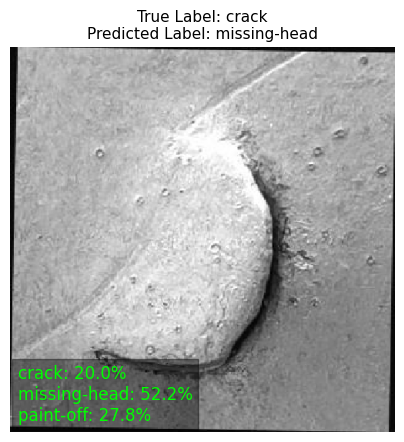

Saved: /content/figures/test_test_crack.jpg.png


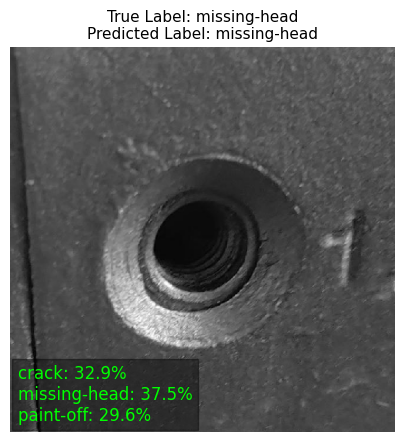

Saved: /content/figures/test_test_missinghead.jpg.png


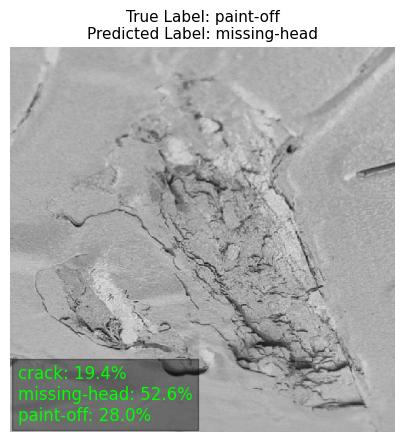

Saved: /content/figures/test_test_paintoff.jpg.png


In [8]:
# Step 5.4: Inference on the three required test images

tests = [
    # Define each test case
    ("crack",        os.path.join(TEST_ROOT, "crack",        "test_crack.jpg")),
    ("missing-head", os.path.join(TEST_ROOT, "missing-head", "test_missinghead.jpg")),
    ("paint-off",    os.path.join(TEST_ROOT, "paint-off",    "test_paintoff.jpg")),
]

# Loop through each test image
for true_label, path in tests:
    img_PIL, x = preprocess_image(path, target_size=TARGET_SIZE)
    probs, pred_idx, pred_label = predict_softmax(x)
    save_to = f"/content/figures/test_{os.path.basename(path)}.png"
    draw_result(img_PIL, probs, pred_label, true_label=true_label, save_path=save_to)
    print(f"Saved: {save_to}")


In [9]:
# Step 5.5 (optional): Evaluate accuracy over the whole test/ directory

from tensorflow.keras.preprocessing import image_dataset_from_directory
test_ds = image_dataset_from_directory(
    TEST_ROOT,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=TARGET_SIZE,
    batch_size=32,
    shuffle=False,
    class_names=class_names  # <— enforce same class order as training
)

def scale(x, y): return (tf.cast(x, tf.float32) / 255.0, y)
test_ds = test_ds.map(scale)

loss, acc = model.evaluate(test_ds, verbose=0)
print(f"Test set — loss: {loss:.4f}, accuracy: {acc:.4f}")

Found 539 files belonging to 3 classes.
Test set — loss: 1.1280, accuracy: 0.3711
